In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os

# Add the src directory to the Python path
src_path = os.path.join(os.getcwd(), 'src')
if src_path not in sys.path:
    sys.path.append(src_path)

In [22]:
import numpy as np
import random
import ast
import pandas as pd
import itertools
from itertools import product
import csv
from src.data_preprocessing import *
from sklearn.model_selection import train_test_split
from src.optimizers import *
from src.activation_functions import * 
from src.utils import *
from src.model_regularization import *
from src.layer import *
from src.batch_normalization import *
from loss_functions import *
from src.neural_network import *
from src.train_and_evaluate import *
from src.random_search import *
from src.k_fold_cross_validation import *
# from src.random_search import *
np.random.seed(0)


<!-- #### Data pre-processing for MONK Datasets  -->

In [4]:
X_train, y_train = load_data(MONK_NUM=2)
X_test, y_test = load_data(MONK_NUM=2, train=False)

one hot encoded data:  (169, 17)
one hot encoded data:  (432, 17)


Training set size: 135
Validation set size: 432
Training set overlap with validation set: 2


In [5]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42)
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)
X_val = np.asarray(X_val)
y_val = np.asarray(y_val)

In [20]:
print("Training set size:", len(X_train))
print("Validation set size:", len(X_val))
print("Training set overlap with validation set:",
      np.intersect1d(X_train, X_val).shape[0])

Training set size: 135
Validation set size: 34
Training set overlap with validation set: 2


In [6]:
# Print the shape of the resulting datasets
for _ in [X_train, X_val, y_train, y_val]:
    print(f"the shape: ", _.shape)

the shape:  (135, 17)
the shape:  (34, 17)
the shape:  (135,)
the shape:  (34,)


In [12]:
param_distributions = {
    'hidden_size': [[3], [4], [5], [6]],
    'hidden_activation': [[Activation_Tanh], [Activation_Leaky_ReLU], [Activation_Sigmoid], [Activation_ReLU]],
    'batch_norm': [[True], [False]],
    'learning_rate': [1e-4, 1e-3, 1e-2, 1e-1],
    'l1': [0.0, 1e-5, 1e-4, 1e-3, 1e-2],
    'l2': [0.0, 1e-5, 1e-4, 1e-3, 1e-2],
    'dropout_rate': [0.0, 0.1, 0.3],
    'batch_size': [1000],
    'n_epochs': [150, 200],
    # # Define combinations of hidden layer sizes and corresponding activations
    # 'hidden_configs': [
    #     {'hidden_size': [10], 'hidden_activation': [Activation_Tanh], 'batch_norm' : [True]},
    #     {'hidden_size': [10, 10], 'hidden_activation': [Activation_Leaky_ReLU, Activation_ELU], 'batch_norm' : [True, True]},
    #     {'hidden_size': [10, 10], 'hidden_activation': [Activation_Leaky_ReLU, Activation_ELU], 'batch_norm' : [True, True]},
    #     {'hidden_size': [20, 20], 'hidden_activation': [Activation_Leaky_ReLU, Activation_ELU], 'batch_norm' : [True, False]},
    #     {'hidden_size': [20, 20], 'hidden_activation': [Activation_Leaky_ReLU, Activation_ELU], 'batch_norm' : [True, True]},
    #     {'hidden_size': [20, 20], 'hidden_activation': [Activation_ELU, Activation_ELU], 'batch_norm' : [True, False]},
    #     {'hidden_size': [10, 10], 'hidden_activation': [Activation_Leaky_ReLU, Activation_ELU], 'batch_norm' : [True, False]},
    #     {'hidden_size': [32, 16], 'hidden_activation': [Activation_Leaky_ReLU, Activation_Sigmoid], 'batch_norm' : [False, True]},  
    #     {'hidden_size': [30, 30], 'hidden_activation': [Activation_Leaky_ReLU, Activation_ELU], 'batch_norm' : [True, False]},
    #     {'hidden_size': [64, 32, 16], 'hidden_activation': [Activation_ReLU, Activation_ReLU, Activation_Tanh], 'batch_norm' : [True, False, True]},
    #     {'hidden_size': [30, 30], 'hidden_activation': [Activation_Leaky_ReLU, Activation_ELU], 'batch_norm': [True, False]}
    # ]   
}

TODO:

Create a seperate best_results csv file for each MONK 

In [13]:
best_hyperparams, best_performance = random_search(X_train=X_train,
                                                   y_train=y_train,
                                                   X_val=X_val,
                                                   y_val=y_val,
                                                   param_distributions=param_distributions,
                                                   n_iters=50)  # adjust n_iters as needed

print(best_hyperparams)

[4] [<class 'src.activation_functions.Activation_ReLU'>] [0.1] [True]
[4] [<class 'src.activation_functions.Activation_Leaky_ReLU'>] [0.3] [True]
[3] [<class 'src.activation_functions.Activation_ReLU'>] [0.3] [False]
[3] [<class 'src.activation_functions.Activation_Tanh'>] [0.1] [False]
[3] [<class 'src.activation_functions.Activation_ReLU'>] [0.0] [False]
[5] [<class 'src.activation_functions.Activation_Sigmoid'>] [0.0] [True]
[3] [<class 'src.activation_functions.Activation_Sigmoid'>] [0.3] [True]
[5] [<class 'src.activation_functions.Activation_Leaky_ReLU'>] [0.3] [False]
[3] [<class 'src.activation_functions.Activation_ReLU'>] [0.1] [False]
[3] [<class 'src.activation_functions.Activation_ReLU'>] [0.1] [True]
[6] [<class 'src.activation_functions.Activation_Tanh'>] [0.1] [False]
[6] [<class 'src.activation_functions.Activation_Leaky_ReLU'>] [0.1] [False]
[3] [<class 'src.activation_functions.Activation_ReLU'>] [0.1] [True]
[4] [<class 'src.activation_functions.Activation_ReLU'>] [0

In [14]:
learning_rate, l1, l2, dropout_rate, batch_size, n_epochs, hidden_size, hidden_activation, use_batch_norm, validation_accuracy = best_hyperparams.values()
learning_rate, l1, l2, dropout_rate, batch_size, n_epochs, hidden_size, hidden_activation, use_batch_norm

(0.1, 0.001, 0.0, 0.1, 1000, 150, [6], ['Activation_Tanh'], [False])

GRID SEARCH

In [15]:
activation_map = {
    'Activation_ReLU': Activation_ReLU,
    'Activation_Tanh': Activation_Tanh,
    'Activation_ELU': Activation_ELU,
    'Activation_Leaky_ReLU': Activation_Leaky_ReLU,
    'Activation_Sigmoid': Activation_Sigmoid
}

hidden_activation = [activation_map[act] for act in hidden_activation]  

In [16]:

model = NN(
    l1=l1,
    l2=l2,
    input_size=17,
    hidden_sizes=hidden_size,
    output_size=1,
    hidden_activations=hidden_activation,
    dropout_rates=[dropout_rate],
    use_batch_norm=use_batch_norm
)
batch_size = batch_size
learning_rate = learning_rate
n_epochs = n_epochs

[6] [<class 'src.activation_functions.Activation_Tanh'>] [0.1] [False]


In [17]:
# model = NN(l1=0.01,
#            l2=0.1,
#            input_size=17,
#            hidden_sizes=[30, 30],
#            output_size=1,
#            hidden_activations=[Activation_Leaky_ReLU, Activation_Tanh],
#            dropout_rates=[0.1, 0.1],
#            use_batch_norm=[False, True],
#            )

# batch_size = 10000
# learning_rate = 0.003
# n_epochs = 300

Data shapes:
X_train: (135, 17), y_train: (135,)
Sample prediction: [[0.08746203]]
Initial loss: 0.007649606528735337
Epoch 0: Train Loss: 0.4761, Acc: 57.04% | Val Loss: 0.8225, Acc: 41.18%
Epoch 10: Train Loss: 0.3018, Acc: 44.44% | Val Loss: 0.2527, Acc: 50.00%
Epoch 20: Train Loss: 0.2401, Acc: 56.30% | Val Loss: 0.2527, Acc: 52.94%
Epoch 30: Train Loss: 0.2259, Acc: 66.67% | Val Loss: 0.3339, Acc: 44.12%
Epoch 40: Train Loss: 0.1953, Acc: 68.15% | Val Loss: 0.3554, Acc: 41.18%
Epoch 50: Train Loss: 0.1943, Acc: 62.96% | Val Loss: 0.3308, Acc: 41.18%
Epoch 60: Train Loss: 0.1806, Acc: 71.11% | Val Loss: 0.3193, Acc: 44.12%
Epoch 70: Train Loss: 0.1751, Acc: 77.04% | Val Loss: 0.2986, Acc: 61.76%
Epoch 80: Train Loss: 0.1422, Acc: 82.22% | Val Loss: 0.2981, Acc: 76.47%
Epoch 90: Train Loss: 0.0882, Acc: 90.37% | Val Loss: 0.3378, Acc: 100.00%
Epoch 100: Train Loss: 0.0903, Acc: 86.67% | Val Loss: 0.3685, Acc: 100.00%
Early stopping at epoch 107
Restoring model weights from epoch 7
F

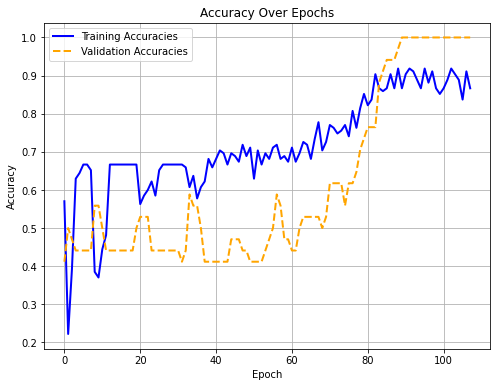

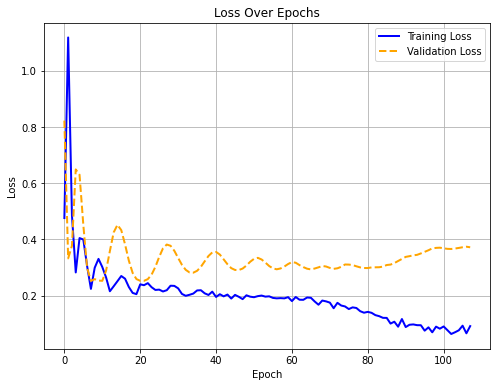

Test Accuracy: 1.0000


In [18]:
import copy

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

loss_function = MSE()
optimizer = Optimizer_Adam(learning_rate=learning_rate, decay=1e-3)

# Initialize early stopping
early_stopping = EarlyStopping(patience=100, min_delta_loss=1e-5, min_delta_accuracy=0.001)

# Before training loop:
print("Data shapes:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Sample prediction: {model.forward(X_train[:1])}")
print(f"Initial loss: {loss_function.forward(model.output, y_train[:1])}")

# Training loop
for epoch in range(n_epochs):
    batch_losses = []
    batch_accuracies = []

    for X_batch, y_batch in create_batches(X_train, y_train, batch_size):
        # Forward pass
        model.forward(X_batch, training=True)

        # Loss and accuracy
        loss = loss_function.forward(model.output, y_batch)
        predictions = np.round(model.output.squeeze())
        accuracy = np.mean(predictions == y_batch.squeeze())

        # Backward pass
        loss_function.backward(model.output, y_batch)
        dvalues = loss_function.dinputs

        assert dvalues.shape == model.output.shape, \
            f"Gradient shape mismatch: {dvalues.shape} vs {model.output.shape}"

        for layer in reversed(model.layers):
            layer.backward(dvalues)
            dvalues = layer.dinputs

            # Regularization
            if isinstance(layer, Layer_Dense):
                if layer.l1 > 0:
                    layer.dweights += layer.l1 * np.sign(layer.weights)
                if layer.l2 > 0:
                    layer.dweights += 2 * layer.l2 * layer.weights

        # Update weights
        optimizer.pre_update_params()
        for layer in model.layers:
            if isinstance(layer, Layer_Dense):
                optimizer.update_params(layer)
        optimizer.post_update_params()

        batch_losses.append(loss)
        batch_accuracies.append(accuracy)

    # Epoch summary
    epoch_loss = np.mean(batch_losses)
    epoch_acc = np.mean(batch_accuracies)
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    # Validation
    X_val_input = X_val.values if isinstance(X_val, pd.DataFrame) else X_val
    y_val_input = y_val.values if isinstance(y_val, (pd.Series, pd.DataFrame)) else y_val

    model.forward(X_val_input, training=False)
    val_loss = loss_function.forward(model.output, y_val_input)
    val_predictions = np.round(model.output.squeeze())
    val_accuracy = np.mean(val_predictions == y_val.squeeze())

    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    if epoch % 10 == 0:
        print(f"Epoch {epoch}: ", end="")
        print(f"Train Loss: {epoch_loss:.4f}, Acc: {epoch_acc*100:.2f}% | ", end="")
        print(f"Val Loss: {val_loss:.4f}, Acc: {val_accuracy*100:.2f}%")

    # Early stopping check
    early_stopping.on_epoch_end(
        current_loss=val_loss,
        current_accuracy=val_accuracy,
        model=model.layers,
        epoch=epoch
    )

    if early_stopping.stop_training:
        print(f"Early stopping at epoch {epoch}")
        break

# Restore best weights
if early_stopping.stop_training:
    print(f"Restoring model weights from epoch {early_stopping.best_epoch}")
    early_stopping.restore_weights(model.layers)

# Final evaluation
model.forward(X_val_input, training=False)
final_val_loss = loss_function.forward(model.output, y_val_input)
final_val_accuracy = np.mean(np.round(model.output.squeeze()) == y_val.squeeze())
print(f"Final Validation Accuracy: {final_val_accuracy:.4f}")

# Plot training progress
plot_accuracies(train_accuracies, val_accuracies,
                label1="Training Accuracies", label2="Validation Accuracies",
                title="Accuracy Over Epochs")

plot_losses(train_losses, val_losses,
            label1="Training Loss", label2="Validation Loss",
            title="Loss Over Epochs")

# Test set evaluation
model.forward(X_test, training=False)
loss_function.forward(model.output.squeeze(), y_test)

predictions = np.round(model.output.squeeze())
y_true = np.argmax(y_test, axis=1) if y_test.ndim > 1 else y_test
test_accuracy = np.mean(predictions == y_true)
print(f"Test Accuracy: {test_accuracy:.4f}")

In [ ]:
print(train_losses, val_losses)

In [ ]:
model.forward(X_test, training=False)
# Compute softmax probabilities for the test output
# print(X_test.shape, y_test.shape)
# print(model.output, y_test)
loss_function.forward(model.output.squeeze(), y_test)
# Calculate accuracy for the test set
predictions = np.round(model.output.squeeze())
if len(y_test.shape) == 2:
    y_true = np.argmax(y_test, axis=1)
else:
    y_true = y_test

# Compute test accuracy
test_accuracy = np.mean(predictions == y_true)
print(f"Test Accuracy: {test_accuracy:.4f}")

In [ ]:
# train_losses = []
# train_accuracies = []
# val_losses = []
# val_accuracies = []

# loss_function = MSE()
# optimizer = Optimizer_Adam(learning_rate=learning_rate, decay=1e-3)
# # Before training loop:
# print("Data shapes:")
# print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
# print(f"Sample prediction: {model.forward(X_train[:1])}")  # Should output ~0.5
# print(
#     f"Initial loss: {loss_function.forward(model.output, y_train[:1])}")
# # Training loop
# for epoch in range(n_epochs):
#     batch_losses = []
#     batch_accuracies = []

#     for X_batch, y_batch in create_batches(X_train, y_train, batch_size):
#         # Forward pass
#         model.forward(X_batch, training=True)

#         # Calculate loss
#         loss = loss_function.forward(model.output, y_batch)
#         predictions = np.round(model.output.squeeze())
#         accuracy = np.mean(predictions == y_batch.squeeze())

#         # Backward pass with shape validation
#         loss_function.backward(model.output, y_batch)

#         dvalues = loss_function.dinputs

#         # Verify gradient shape matches output
#         assert dvalues.shape == model.output.shape, \
#             f"Gradient shape mismatch: {dvalues.shape} vs {model.output.shape}"

#         # Propagate gradients
#         for layer in reversed(model.layers):
#             layer.backward(dvalues)
#             dvalues = layer.dinputs
#             # Apply L1/L2 regularization to dense layers
#             if isinstance(layer, Layer_Dense):
#                 if layer.l1 > 0:
#                     layer.dweights += layer.l1 * np.sign(layer.weights)
#                 if layer.l2 > 0:
#                     layer.dweights += 2 * layer.l2 * layer.weights
#             # Ensure numpy arrays
#             if isinstance(dvalues, pd.DataFrame):
#                 dvalues = dvalues.values
#             elif isinstance(dvalues, pd.Series):
#                 dvalues = dvalues.values.reshape(-1, 1)

#         # Update parameters
#         optimizer.pre_update_params()
#         for layer in model.layers:
#             if isinstance(layer, Layer_Dense):
#                 optimizer.update_params(layer)
#         optimizer.post_update_params()

#         batch_losses.append(loss)
#         batch_accuracies.append(accuracy)

#     # Epoch metrics
#     epoch_loss = np.mean(batch_losses)
#     epoch_acc = np.mean(batch_accuracies)
#     train_losses.append(epoch_loss)
#     train_accuracies.append(epoch_acc)
#     # Validation pass
#     model.forward(X_val.values if isinstance(X_val, pd.DataFrame) else X_val,
#                   training=False)

#     val_loss = loss_function.forward(model.output, y_val.values if isinstance(
#         y_val, (pd.Series, pd.DataFrame)) else y_val)
#     val_predictions = np.round(model.output.squeeze())
#     val_accuracy = np.mean(val_predictions == y_val.squeeze())

#     val_losses.append(val_loss)
#     val_accuracies.append(val_accuracy)

#     # Progress reporting
#     if epoch % 10 == 0:  # More frequent updates
#         print(f"Epoch {epoch}: ", end="")
#         print(f"Train Loss: {epoch_loss}, Acc: {epoch_acc*100} % | ", end="")
#         print(f"Val Loss: {val_loss}, Acc: {val_accuracy*100} % ")

    
#     early_stopping.on_epoch_end(
#         current_loss=val_loss,
#         current_accuracy=val_accuracy,
#         model=[dense1, dense2], 
#         epoch=epoch
#     )
#     if early_stopping.stop_training:
#         print(f"Early stopping at epoch {epoch}")
#         break
# # Final validation with restored weights
# model.forward(X_val.values if isinstance(
#     X_val, pd.DataFrame) else X_val, training=False)
# final_val_loss = loss_function.forward(model.output, y_val.values if isinstance(
#     y_val, (pd.Series, pd.DataFrame)) else y_val)
# final_val_accuracy = np.mean(np.argmax(model.output, axis=1) == y_val)
# final_val_accuracy = np.mean(
#     np.round(model.output.squeeze()) == y_val.squeeze())

# plot_accuracies(train_accuracies, val_accuracies, label1="Training Accuracies",
#                 label2="Validation Accuracies", title="Accuracy Over Epochs")
# plot_losses(train_losses, val_losses, label1="Training Loss",
#             label2="Validation Loss", title="Loss Over Epochs")

# model.forward(X_test, training=False)
# loss_function.forward(model.output.squeeze(), y_test)
# # Calculate accuracy for the test set
# predictions = np.round(model.output.squeeze())
# y_true = np.argmax(y_test, axis=1) if y_test.ndim > 1 else y_test

# # Compute test accuracy
# test_accuracy = np.mean(predictions == y_true)
# print(f"Test Accuracy: {test_accuracy:.4f}")

In [ ]:
# # Step 1: Read the top 20 rows
# df = pd.read_csv('top_5_results.csv').head(20)

# # Step 2: Parse string-encoded lists and classes
# def parse_value(val):
#     try:
#         return ast.literal_eval(val)
#     except (ValueError, SyntaxError):
#         return val

# for col in ['hidden_size', 'hidden_activation', 'batch_norm']:
#     df[col] = df[col].apply(parse_value)

# # print(df.head())
# # Step 3: Extract unique values of hyperparameters
# param_grid = {
#     'learning_rate': df['learning_rate'].unique(),
#     'l1': df['l1'].unique(),
#     'l2': df['l2'].unique(),
#     'dropout_rate': df['dropout_rate'].unique(),
#     'batch_size': df['batch_size'].unique(),
#     'n_epochs': df['n_epochs'].unique(),
#     'hidden_size': df['hidden_size'].apply(lambda x: tuple(x) if isinstance(x, list) else x),
#     'hidden_activation': df['hidden_activation'].unique(),
#     'batch_norm': df['batch_norm'].apply(lambda x: tuple(x) if isinstance(x, list) else x),
# }

# # Step 4: Create combinations of all unique hyperparameters
# all_combinations = list(itertools.product(*param_grid.values()))

# # Step 5: Search for best hyperparameter combo
# best_val_acc = -1
# best_config = None

# for combo in all_combinations:
#     config = dict(zip(param_grid.keys(), combo))
#     print(config)
#     # Unpack config and call your training function
#     # model = NN(
#     #     hidden_sizes=config['hidden_size'],
#     #     activations=config['hidden_activation'],
#     #     batch_norms=config['batch_norm'],
#     #     l1=config['l1'],
#     #     l2=config['l2'],
#     #     dropout_rate=config['dropout_rate']
#     # )
#     model = NN(
#            l1=config["l1"],
#            l2=config["l2"],
#            input_size=17,
#            hidden_sizes=config["hidden_size"],
#            output_size=1,
#            hidden_activations= config["hidden_activation"],
#            dropout_rates=[config["dropout_rate"]],
#            use_batch_norm=config["batch_norm"],
#            )

#     _, val_acc = train_and_evaluate(
#         X_train, y_train, X_val, y_val,
#         learning_rate=config['learning_rate'],
#         n_epochs=config['n_epochs'],
#         batch_size=config['batch_size'],
#         model=model
#     )

#     if val_acc > best_val_acc:
#         best_val_acc = val_acc
#         best_config = config

# print("Best validation accuracy:", best_val_acc)
# print("Best hyperparameter configuration:")
# for k, v in best_config.items():
#     print(f"{k}: {v}")

GRID SEARCH

In [ ]:
# # === Activation function mapping ===
# activation_map = {
#     "Activation_Linear": Activation_Linear,
#     "Activation_Leaky_ReLU": Activation_Leaky_ReLU,
#     "Activation_Sigmoid": Activation_Sigmoid,
#     "Activation_Tanh": Activation_Tanh,
#     "Activation_ELU": Activation_ELU,
#     "Activation_Softmax": Activation_Softmax,
#     "Activation_ReLU": Activation_ReLU
# }

# # === Step 1: Read the top 20 rows ===
# df = pd.read_csv('top_5_results.csv').head(5)

# # === Step 2: Parse string-encoded lists and map activations ===
# def parse_value(val):
#     try:
#         return ast.literal_eval(val)
#     except (ValueError, SyntaxError):
#         return val

# def parse_activations(val):
#     try:
#         names = ast.literal_eval(val) if isinstance(val, str) else val
#         return [activation_map[name] for name in names]
#     except Exception as e:
#         raise ValueError(f"Error parsing activation functions: {val}") from e

# # Apply parsing
# df['hidden_size'] = df['hidden_size'].apply(parse_value)
# df['batch_norm'] = df['batch_norm'].apply(parse_value)
# df['hidden_activation'] = df['hidden_activation'].apply(parse_activations)

# # === Step 3: Extract unique values of hyperparameters ===
# param_grid = {
#     'learning_rate': df['learning_rate'].unique(),
#     'l1': df['l1'].unique(),
#     'l2': df['l2'].unique(),
#     'dropout_rate': df['dropout_rate'].unique(),
#     'batch_size': df['batch_size'].unique(),
#     'n_epochs': df['n_epochs'].unique(),
#     'hidden_size': df['hidden_size'].apply(lambda x: tuple(x) if isinstance(x, list) else x).unique(),
#     'hidden_activation': df['hidden_activation'].apply(lambda x: tuple(x) if isinstance(x, list) else x).unique(),
#     'batch_norm': df['batch_norm'].apply(lambda x: tuple(x) if isinstance(x, list) else x).unique(),
# }
# print(param_grid)
# print("*"*50)
# print("THE NUMBER OF PERMUTATIONS WE HAVE IS : " , count_permutations(param_grid))
# print("*"*50)
# # === Step 4: Create combinations of all unique hyperparameters ===
# all_combinations = list(itertools.product(*param_grid.values()))

# # === Step 5: Search for best hyperparameter combo ===
# best_val_acc = -1
# best_config = None

# for combo in all_combinations:
#     config = dict(zip(param_grid.keys(), combo))

#     hidden_sizes = config["hidden_size"]
#     hidden_activations = config["hidden_activation"]
#     batch_norms = config["batch_norm"]

#     # Ensure all layer-related components are of the same length
#     if not (len(hidden_sizes) == len(hidden_activations) == len(batch_norms)):
#         print("Skipping due to length mismatch:", config)
#         continue  # Skip this invalid configuration

#     model = NN(
#         l1=config["l1"],
#         l2=config["l2"],
#         input_size=17,
#         hidden_sizes=hidden_sizes,
#         output_size=1,
#         hidden_activations=hidden_activations,
#         dropout_rates=[config["dropout_rate"]],  # can be broadcasted inside NN
#         use_batch_norm=batch_norms,
#     )

#     _, val_acc = train_and_evaluate(
#         X_train, y_train, X_val, y_val,
#         learning_rate=config['learning_rate'],
#         n_epochs=config['n_epochs'],
#         batch_size=config['batch_size'],
#         model=model
#     )

#     if val_acc > best_val_acc:
#         best_val_acc = val_acc
#         best_config = config

# # === Step 6: Output best result ===
# print("Best validation accuracy:", best_val_acc)
# print("Best hyperparameter configuration:")
# for k, v in best_config.items():
#     print(f"{k}: {v}")

{'learning_rate': array([0.1  , 0.001, 0.01 ]), 'l1': array([1.e-03, 0.e+00, 1.e-05]), 'l2': array([0.01  , 0.001 , 0.    , 0.0001]), 'dropout_rate': array([0.1, 0. ]), 'batch_size': array([1000,    2], dtype=int64), 'n_epochs': array([200, 150], dtype=int64), 'hidden_size': array([(20, 20), (30, 30), (32, 16), (10,), (64, 32, 16)], dtype=object), 'hidden_activation': array([(<class 'src.activation_functions.Activation_ReLU'>, <class 'src.activation_functions.Activation_ELU'>),
       (<class 'src.activation_functions.Activation_Leaky_ReLU'>, <class 'src.activation_functions.Activation_ELU'>),
       (<class 'src.activation_functions.Activation_Leaky_ReLU'>, <class 'src.activation_functions.Activation_Sigmoid'>),
       (<class 'src.activation_functions.Activation_Tanh'>,),
       (<class 'src.activation_functions.Activation_ReLU'>, <class 'src.activation_functions.Activation_ReLU'>, <class 'src.activation_functions.Activation_Tanh'>)],
      dtype=object), 'batch_norm': array([(True, 

KeyboardInterrupt: 